In [13]:
import numpy as np
import itertools
import os
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, recall_score, balanced_accuracy_score, roc_auc_score, confusion_matrix
import csv
import joblib

# Set seed for reproducibility
def set_seed(seed_value=42):
    np.random.seed(seed_value)

set_seed(42)

# Load dataset
file_path = 'diabetes.csv'
df = pd.read_csv(file_path)

print(df.info())

# Replace zeros with NaN where applicable
df['BloodPressure'] = df['BloodPressure'].replace(0, np.nan)
df['SkinThickness'] = df['SkinThickness'].replace(0, np.nan)
df['Insulin'] = df['Insulin'].replace(0, np.nan)
df['BMI'] = df['BMI'].replace(0, np.nan)

# Calculate the percentage of outcome 0 vs 1
outcome_counts = df['Outcome'].value_counts(normalize=True) * 100

# Print the outcome percentages
print(outcome_counts)


# Calculate class weights (inverse of the class proportions)
balanced_class_weight = {0: 1 / outcome_counts[0], 1: 1 / outcome_counts[1]}

# Print class weights
print(balanced_class_weight)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None
Outcome
0    65.104167
1    34.895833
Name: proportion, dtype: float64
{0: 0.015360000000000002, 1: 0.02865671641791045}


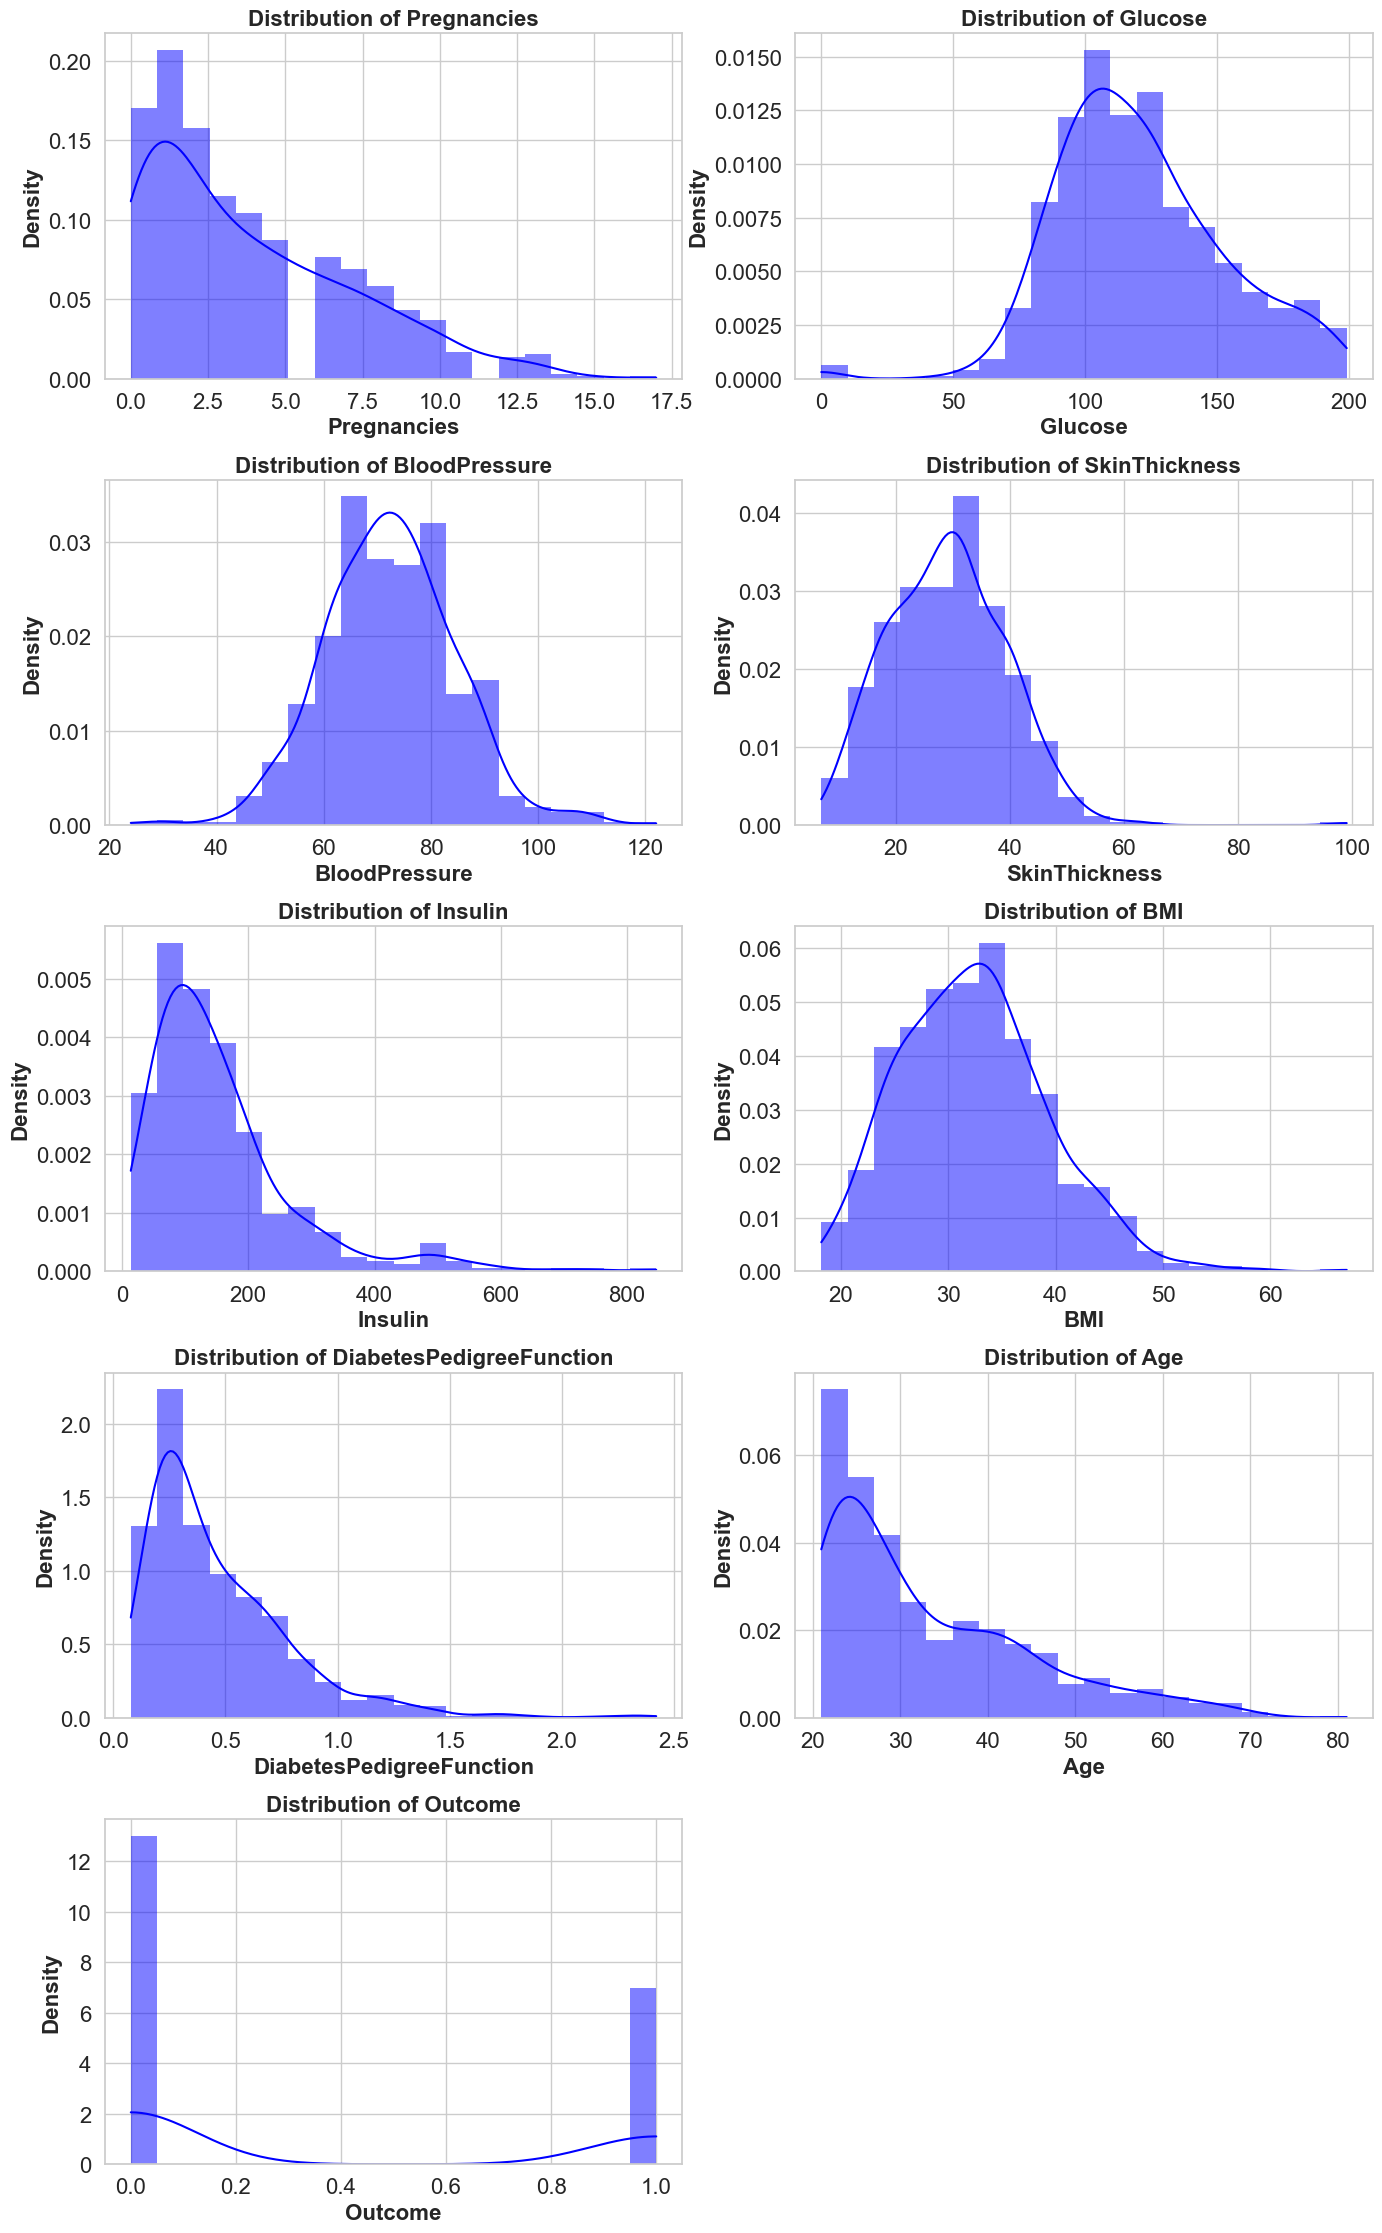

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style for better visualization
sns.set(style="whitegrid")

# Get all the numeric columns, including 'Outcome'
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Set up the subplot layout: 2 histograms per row
fig, axes = plt.subplots(len(numeric_columns) // 2 + len(numeric_columns) % 2, 2, figsize=(14, len(numeric_columns) * 2.5))

# Flatten the axes array to easily index into it
axes = axes.flatten()

# Plot histogram with KDE for each numerical feature, including Outcome
for i, column in enumerate(numeric_columns):
    sns.histplot(df[column], bins=20, kde=True, color='blue', stat='density', linewidth=0, ax=axes[i])
    
    # Set titles and labels with bigger, bold fonts
    axes[i].set_title(f'Distribution of {column}', fontsize=16, weight='bold')
    axes[i].set_xlabel(column, fontsize=16, weight='bold')
    axes[i].set_ylabel('Density', fontsize=16, weight='bold')
    
    # Set tick parameters with larger font size
    axes[i].tick_params(axis='both', which='major', labelsize=16)

# Remove empty subplots if any
if len(numeric_columns) % 2 != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()


In [16]:
import numpy as np
import itertools
import os
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, recall_score, balanced_accuracy_score, roc_auc_score, confusion_matrix
import csv
import joblib

# Set seed for reproducibility
def set_seed(seed_value=42):
    np.random.seed(seed_value)

set_seed(42)

# Load dataset
file_path = 'diabetes.csv'
df = pd.read_csv(file_path)

print(df.describe())

# Replace zeros with NaN where applicable
df['BloodPressure'] = df['BloodPressure'].replace(0, np.nan)
df['SkinThickness'] = df['SkinThickness'].replace(0, np.nan)
df['Insulin'] = df['Insulin'].replace(0, np.nan)
df['BMI'] = df['BMI'].replace(0, np.nan)

# Define the feature columns
robust_columns = ['Insulin', 'SkinThickness', 'Glucose', 'BMI', 'Age', 'DiabetesPedigreeFunction', 'Pregnancies']
standard_columns = ['BloodPressure']
target_column = 'Outcome'

# Prepare X and y
X = df[robust_columns + standard_columns]
y = df[target_column]

# Split the dataset into train and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)

# Implementing a basic Perceptron model from scratch with class weighting and early stopping
class PerceptronScratch:
    def __init__(self, input_dim, learning_rate=0.001, class_weight={0: 1, 1: 1}, l1_penalty=0.0, l2_penalty=0.0):
        self.weights = np.zeros(input_dim)
        self.bias = 0
        self.learning_rate = learning_rate
        self.class_weight = class_weight  # Class weights
        self.l1_penalty = l1_penalty  # L1 regularization
        self.l2_penalty = l2_penalty  # L2 regularization

    def activation(self, z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))  # Sigmoid activation function

    def loss(self, y_true, y_pred):
        """Compute binary cross-entropy loss"""
        y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
        return -y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred)

    def predict(self, X):
        linear_output = np.dot(X, self.weights) + self.bias
        return self.activation(linear_output)

    def train(self, X, y, X_val, y_val, num_epochs=100, early_stopping_patience=20):
        best_weights = None
        best_bias = None
        best_val_loss = np.inf  # Track validation loss
        patience_counter = 0

        for epoch in range(num_epochs):
            for i in range(X.shape[0]):
                linear_output = np.dot(X[i], self.weights) + self.bias
                y_pred = self.activation(linear_output)

                # Compute class weight based on the true label
                class_w = self.class_weight[y[i]]

                # Compute the error
                error = y[i] - y_pred

                # Update weights with L1 and L2 regularization
                self.weights += self.learning_rate * class_w * error * X[i]
                # Apply L1 penalty (Lasso)
                self.weights -= self.learning_rate * self.l1_penalty * np.sign(self.weights)
                # Apply L2 penalty (Ridge)
                self.weights -= self.learning_rate * self.l2_penalty * self.weights

                self.bias += self.learning_rate * class_w * error

            # Evaluate on the validation set at the end of each epoch
            y_val_pred = self.predict(X_val)
            val_loss = np.mean(self.loss(y_val, y_val_pred))  # Compute validation loss

            # Early stopping check: save the best weights if the validation loss improves
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_weights = np.copy(self.weights)  # Save best weights
                best_bias = self.bias
                patience_counter = 0  # Reset patience counter
            else:
                patience_counter += 1

            # If patience counter exceeds the early_stopping_patience, stop training
            if patience_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch + 1}. Reverting to best weights.")
                self.weights = best_weights  # Revert to best weights
                self.bias = best_bias
                break

    def evaluate(self, X):
        linear_output = np.dot(X, self.weights) + self.bias
        predictions = self.activation(linear_output)
        return np.where(predictions >= 0.5, 1, 0)  # Convert probabilities to binary output

    def predict_proba(self, X):
        """Get the probability predictions"""
        linear_output = np.dot(X, self.weights) + self.bias
        return self.activation(linear_output)  # Probabilities for AUC calculation

    def save_model(self, filename):
        """Save the model (weights and bias) to a file."""
        np.savez(filename, weights=self.weights, bias=self.bias)
        print(f"Model saved to {filename}")

    def load_model(self, filename):
        """Load the model (weights and bias) from a file."""
        model_data = np.load(filename)
        self.weights = model_data['weights']
        self.bias = model_data['bias']
        print(f"Model loaded from {filename}")


# Perform cross-validation and store OOF predictions, probabilities, and labels
def cross_validate_perceptron_with_early_stopping(X, y, num_epochs=100, learning_rate=0.001, class_weight={0: 1, 1: 1},
                                                  l1_penalty=0.0, l2_penalty=0.0, cv_splits=10,
                                                  early_stopping_patience=10,
                                                  output_csv="training_results.csv", file_name='final_model'):
    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)

    oof_predictions = np.zeros(X.shape[0])  # To store out-of-fold predictions
    oof_probabilities = np.zeros(X.shape[0])  # To store predicted probabilities

    cv_scores = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        # Split the data
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Preprocessing pipeline for each fold
        preprocessor = ColumnTransformer(
            transformers=[
                ('robust', Pipeline([
                    ('imputer', SimpleImputer(strategy='median')),
                    ('scaler', RobustScaler())
                ]), robust_columns),
                ('standard', Pipeline([
                    ('imputer', SimpleImputer(strategy='median')),
                    ('scaler', StandardScaler())
                ]), standard_columns)
            ]
        )

        # Preprocess the training and validation data
        X_train_processed = preprocessor.fit_transform(X_train)
        X_val_processed = preprocessor.transform(X_val)

        # Initialize the perceptron with class weighting and regularization penalties
        perceptron = PerceptronScratch(
            input_dim=X_train_processed.shape[1],
            learning_rate=learning_rate,
            class_weight=class_weight,
            l1_penalty=l1_penalty,  # Pass L1 penalty
            l2_penalty=l2_penalty   # Pass L2 penalty
        )

        # Train the perceptron with early stopping based on validation loss
        perceptron.train(X_train_processed, y_train.values, X_val_processed, y_val.values, num_epochs=num_epochs, early_stopping_patience=early_stopping_patience)

        # Get out-of-fold predictions for validation set
        y_pred_val = perceptron.evaluate(X_val_processed)
        y_prob_val = perceptron.predict_proba(X_val_processed)

        # Store OOF predictions and probabilities
        oof_predictions[val_idx] = y_pred_val
        oof_probabilities[val_idx] = y_prob_val

        # Calculate metrics for the fold
        acc = accuracy_score(y_val.values, y_pred_val)
        recall = recall_score(y_val.values, y_pred_val)
        bal_acc = balanced_accuracy_score(y_val.values, y_pred_val)
        auc_score = roc_auc_score(y_val.values, y_prob_val)
        tn, fp, fn, tp = confusion_matrix(y_val.values, y_pred_val).ravel()
        specificity = tn / (tn + fp)

        # Print metrics for each fold
        print(f"Fold {fold + 1} - Accuracy: {acc:.4f}, Recall: {recall:.4f}, Balanced Accuracy: {bal_acc:.4f}, AUC: {auc_score:.4f}, Specificity: {specificity:.4f}")
        cv_scores.append([acc, recall, bal_acc, auc_score, specificity])

    # Calculate and print the average cross-validated metrics
    cv_scores = np.array(cv_scores)
    avg_acc = cv_scores[:, 0].mean()
    avg_recall = cv_scores[:, 1].mean()
    avg_bal_acc = cv_scores[:, 2].mean()
    avg_auc = cv_scores[:, 3].mean()
    avg_specificity = cv_scores[:, 4].mean()

    print(f"\nAverage CV Metrics - Accuracy: {avg_acc:.4f}, Recall: {avg_recall:.4f}, Balanced Accuracy: {avg_bal_acc:.4f}, AUC: {avg_auc:.4f}, Specificity: {avg_specificity:.4f}")

    # Check if the CSV file exists, and if it does not exist or is empty, write the header
    write_header = not os.path.exists(output_csv) or os.path.getsize(output_csv) == 0

    # Log the average results to the CSV at the end of training
    with open(output_csv, mode='a', newline='') as file:
        writer = csv.writer(file)
        if write_header:
            writer.writerow(['filename', 'learning_rate', 'epoch', 'class_weight', 'l1_penalty', 'l2_penalty', 'accuracy', 'recall', 'specificity', 'auc', 'balanced_accuracy'])

        writer.writerow([f'{file_name}.npz', learning_rate, num_epochs, class_weight, l1_penalty, l2_penalty, avg_acc, avg_recall, avg_specificity, avg_auc, avg_bal_acc])

    # Save OOF data
    save_oof_data(f'model/oof_data-{file_name}.npz', oof_predictions, oof_probabilities, y)

    # Save the preprocessor
    save_preprocessor(preprocessor, f'model/Preprocessor-{file_name}.pkl')

    # Save Model Data
    perceptron.save_model(f'model/{file_name}.npz')

    return perceptron, preprocessor


# Save OOF predictions, probabilities, and y to an .npz file
def save_oof_data(filename, oof_predictions, oof_probabilities, y_train):
    np.savez(filename, oof_predictions=oof_predictions, oof_probabilities=oof_probabilities, y_train=y_train)
    print(f"OOF data saved to {filename}")

# Function to save the preprocessor using joblib
def save_preprocessor(preprocessor, filename):
    joblib.dump(preprocessor, filename)
    print(f"Preprocessor saved to {filename}")

from joblib import Parallel, delayed

# Modify run_all_combinations to include L1 and L2 penalties and run in parallel
def run_single_combination(X_train_full, y_train_full, lr, class_weight, l1_penalty, l2_penalty, num_epochs, cv_splits, output_csv, i):
    print(f"Running with learning_rate={lr}, class_weight={class_weight}, L1={l1_penalty}, L2={l2_penalty}")

    # Perform cross-validation and save OOF data, preprocessor, and model
    perceptron, preprocessor = cross_validate_perceptron_with_early_stopping(
        X_train_full, y_train_full,
        num_epochs=num_epochs,
        learning_rate=lr,
        class_weight=class_weight,
        l1_penalty=l1_penalty,  # Pass L1 penalty
        l2_penalty=l2_penalty,  # Pass L2 penalty
        cv_splits=cv_splits,
        early_stopping_patience=10,  # Add patience for early stopping
        output_csv=output_csv,
        file_name=f'Model-{i}'
    )
    return perceptron, preprocessor

def run_all_combinations(X_train_full, y_train_full, learning_rates, class_weights, l1_penalties, l2_penalties, num_epochs=100, cv_splits=10, output_csv="training_results_combinations.csv"):
    param_combinations = list(itertools.product(learning_rates, class_weights, l1_penalties, l2_penalties))

    # Use joblib to parallelize the execution of each parameter combination
    results = Parallel(n_jobs=-1)(delayed(run_single_combination)(
        X_train_full, y_train_full, lr, class_weight, l1_penalty, l2_penalty, num_epochs, cv_splits, output_csv, i
    ) for i, (lr, class_weight, l1_penalty, l2_penalty) in enumerate(param_combinations, 1))

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  

In [2]:
learning_rates = [10, 0.5, 0.2, 0.1, 0.05, 0.01, 0.005, 0.001]
class_weights = [{0: 1, 1: 1}]
l1_penalties = [0.0, 0.5]  # Adjust L1 regularization strength
l2_penalties = [0.0, 0.5]  # Adjust L2 regularization strength

run_all_combinations(X_train_full, y_train_full, learning_rates, class_weights, l1_penalties, l2_penalties, num_epochs=150, cv_splits=10, output_csv="training_results_combinations.csv")

NameError: name 'run_all_combinations' is not defined

In [30]:
result = pd.read_csv('training_results_combinations.csv')

import pandas as pd

# Load the training results
results = pd.read_csv('training_results_combinations.csv')

# Function to get the top 5 models for each metric
def get_top_5_models_for_each_metric(results_df):
    metrics = ['accuracy', 'recall', 'specificity', 'auc', 'balanced_accuracy', 'f1']
    top_5_dict = {}

    for metric in metrics:
        top_5_dict[metric] = results_df[['filename', metric]].sort_values(by=metric, ascending=False).head(5)
    
    return top_5_dict

# Get top 5 models for each metric
top_5_models = get_top_5_models_for_each_metric(results)

# Display the top 5 models for each metric
for metric, top_5 in top_5_models.items():
    print(f"Top 5 models for {metric}:\n{top_5}\n")


,learning_rate,epoch,l1_penalty,l2_penalty,accuracy,recall,specificity,auc,balanced_accuracy
count,2014.000000,2014.0,2014.000000,2014.000000,2014.000000,2014.000000,2014.000000,2014.000000,2014.000000
mean,0.023796,150.0,0.043347,0.043371,0.698804,0.721870,0.686491,0.779985,0.704180
std,0.035194,0.0,0.034498,0.034484,0.035547,0.154611,0.115778,0.031954,0.035683
min,0.000100,150.0,0.000000,0.000000,0.556667,0.179644,0.365172,0.649503,0.545765
25%,0.000500,150.0,0.010000,0.010000,0.676276,0.666008,0.596927,0.765390,0.700346
50%,0.005000,150.0,0.040000,0.050000,0.699301,0.758300,0.677187,0.789013,0.716288
75%,0.050000,150.0,0.070000,0.070000,0.726970,0.833004,0.775664,0.802245,0.724818
max,0.100000,150.0,0.100000,0.100000,0.768415,0.929842,0.950664,0.827930,0.748849


In [31]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix

# Function to load OOF data from a .npz file
def load_oof_data(filename):
    """
    Load OOF predictions, probabilities, and labels from an .npz file.

    Parameters:
    - filename: The path to the .npz file

    Returns:
    - oof_predictions: The OOF predictions
    - oof_probabilities: The OOF predicted probabilities
    - y_train: The true labels (y_train)
    """
    data = np.load(filename)
    oof_predictions = data['oof_predictions']
    oof_probabilities = data['oof_probabilities']
    y_train = data['y_train']
    return oof_predictions, oof_probabilities, y_train

def compute_specificity_sensitivity(y_true, y_prob, threshold):
    """
    Compute specificity and sensitivity (recall) for a given threshold.

    Parameters:
    - y_true: True labels
    - y_prob: Predicted probabilities
    - threshold: The threshold for classification

    Returns:
    - specificity: Specificity at the given threshold
    - sensitivity: Sensitivity (recall) at the given threshold
    """
    # Convert probabilities to binary predictions based on the threshold
    y_pred = np.where(y_prob >= threshold, 1, 0)

    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Sensitivity (Recall) = TP / (TP + FN)
    sensitivity = tp / (tp + fn)

    # Specificity = TN / (TN + FP)
    specificity = tn / (tn + fp)

    return specificity, sensitivity


def tune_threshold_and_plot(oof_probabilities, y_train):
    """
    Tune the threshold and plot specificity vs. sensitivity, and generate ROC curve.

    Parameters:
    - oof_probabilities: Probabilities from out-of-fold predictions
    - y_train: True labels of the training set

    Returns:
    - Optimal threshold where specificity and sensitivity are closest
    """
    thresholds = np.linspace(0.01, 0.99, 100)
    specificities = []
    sensitivities = []

    # Compute specificity and sensitivity for each threshold
    for threshold in thresholds:
        specificity, sensitivity = compute_specificity_sensitivity(y_train, oof_probabilities, threshold)
        specificities.append(specificity)
        sensitivities.append(sensitivity)

    # Plot specificity vs. sensitivity
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, specificities, label='Specificity', linestyle='--')
    plt.plot(thresholds, sensitivities, label='Sensitivity (Recall)', linestyle='-')
    plt.axvline(x=0.5, color='gray', linestyle=':')
    plt.xlabel('Threshold')
    plt.ylabel('Metric Value')
    plt.title('Specificity vs Sensitivity Across Thresholds')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Find and print the optimal threshold where specificity and sensitivity are closest
    differences = np.abs(np.array(specificities) - np.array(sensitivities))
    optimal_idx = np.argmin(differences)
    optimal_threshold = thresholds[optimal_idx]
    print(f"Optimal Threshold (closest specificity and sensitivity): {optimal_threshold:.2f}")
    print(f"At this threshold -> Specificity: {specificities[optimal_idx]:.4f}, Sensitivity: {sensitivities[optimal_idx]:.4f}")

    # Plot ROC Curve
    fpr, tpr, roc_thresholds = roc_curve(y_train, oof_probabilities)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    return optimal_threshold


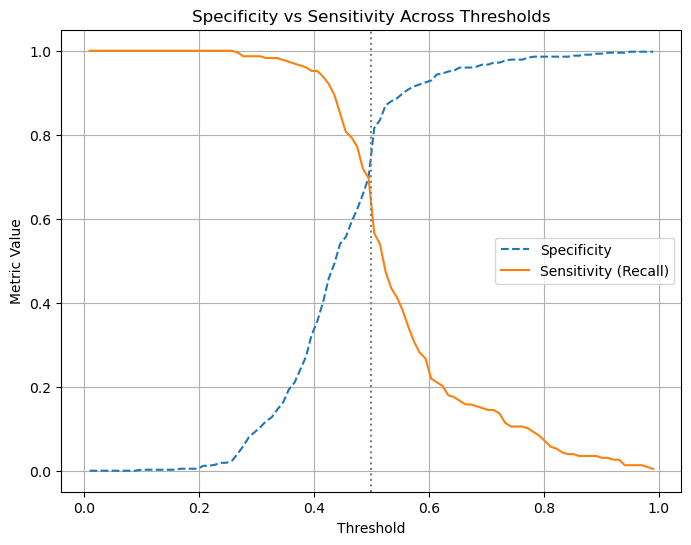

Optimal Threshold (closest specificity and sensitivity): 0.50
At this threshold -> Specificity: 0.6981, Sensitivity: 0.6974


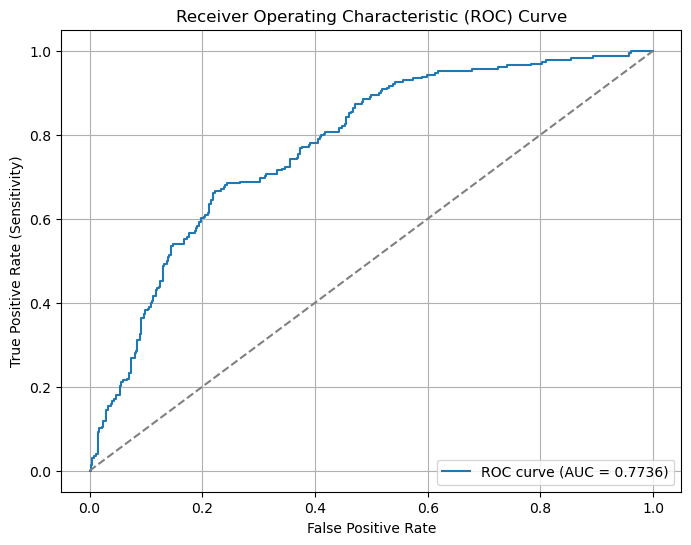

0.495050505050505
Model loaded from model/Model-108.npz

Test Set Metrics with threshold 0.50 - Accuracy: 0.6293, Recall: 0.6750, Balanced Accuracy: 0.6401, AUC: 0.6372, Specificity: 0.6053


(0.6293103448275862,
 0.675,
 0.6401315789473685,
 0.6371710526315789,
 0.6052631578947368)

In [48]:
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, balanced_accuracy_score, roc_auc_score, confusion_matrix

# Function to load the preprocessor using joblib
def load_preprocessor(filename):
    return joblib.load(filename)

def evaluate_perceptron_on_test_with_threshold(X_test, y_test, preprocessor, model_file, threshold=0.5):
    """
    Function to evaluate the Perceptron model on the test set with a specific threshold.

    Parameters:
    - X_test: The test data features
    - y_test: The test data labels
    - preprocessor: The preprocessing pipeline used during training
    - model_file: Path to the saved model file
    - threshold: The threshold to convert probabilities into binary predictions (default is 0.5)

    Returns:
    - Prints the test set metrics
    """
    # Preprocess the test set
    X_test_processed = preprocessor.transform(X_test)

    # Load the trained Perceptron model
    perceptron = PerceptronScratch(input_dim=X_test_processed.shape[1])
    perceptron.load_model(model_file)

    # Get predicted probabilities for the test set
    y_test_prob = perceptron.predict_proba(X_test_processed)

    # Convert probabilities to binary predictions based on the given threshold
    y_test_pred = np.where(y_test_prob >= threshold, 1, 0)

    # Calculate metrics
    test_acc = accuracy_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_bal_acc = balanced_accuracy_score(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_prob)

    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
    test_specificity = tn / (tn + fp)

    # Print the test set results
    print(f"\nTest Set Metrics with threshold {threshold:.2f} - Accuracy: {test_acc:.4f}, Recall: {test_recall:.4f}, Balanced Accuracy: {test_bal_acc:.4f}, AUC: {test_auc:.4f}, Specificity: {test_specificity:.4f}")

    return test_acc, test_recall, test_bal_acc, test_auc, test_specificity

# Evaluate the model on the test set with a custom threshold (e.g., 0.6)
model_number = '108'
threshold = 0.5
# Example usage
# Load OOF data from a specific model file (for example, Model-6.npz)
oof_predictions, oof_probabilities, y_train = load_oof_data(f'model/oof_data-Model-{model_number}.npz')

# Tune the threshold using OOF predictions and generate ROC curve
print(tune_threshold_and_plot(oof_probabilities, y_train))
evaluate_perceptron_on_test_with_threshold(X_test, y_test, load_preprocessor(f'model/Preprocessor-Model-{model_number}.pkl'), f'model/Model-{model_number}.npz', threshold=threshold)
